In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
from data import SimpleDataset, CellImageDataset
import seaborn as sns
import pandas as pd
from sklearn import mixture
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.special import softmax
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from microfilm.colorify import multichannel_to_rgb
from sklearn.cluster import AgglomerativeClustering
import multiscale_phate
import scprep
from glob import glob
from models import PseudoRegressorLit, DINO
from data import RefChannelPseudoDM

In [2]:
imsize = 3 * 256
batch_size = 100
# DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
# NAME = "well_spline_norm_512_crop_sharpness_1250"
DATA_DIR = Path("/data/ishang/CCNB1-dataset/")
NAME = "full_res_768_crop_min_max_border_1250_sharp"

MODEL_DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
MODEL_NAME = "well_spline_norm_512_crop_sharpness_1250"

In [3]:

log_intensities = np.load(MODEL_DATA_DIR / f"FUCCI_log_intensity_labels_{MODEL_NAME}.npy")
fucci_time = np.load(MODEL_DATA_DIR / f"FUCCI_pseudotime_{MODEL_NAME}.npy")

log_dirs_home = Path("/data/ishang/pseudotime_pred/")
checkpoint = "r2z2n8ap"

In [4]:
if checkpoint is not None:
    chkpt_dir_pattern = f"{log_dirs_home}/*/*/*-{checkpoint}/"
    checkpoint_folder = glob(chkpt_dir_pattern)
    if len(checkpoint_folder) > 1:
        raise ValueError(f"Multiple possible checkpoints found: {checkpoint_folder}")
    if len(checkpoint_folder) == 0:
        raise ValueError(f"No checkpoint found for glob pattern: {chkpt_dir_pattern}")
    checkpoint = Path(checkpoint_folder[0]).parent.parent / "lightning_logs" / "last.ckpt"
    if not checkpoint.exists():
        raise ValueError(f"Checkpoint path {checkpoint} does not exist")

model = PseudoRegressorLit.load_from_checkpoint(checkpoint)

In [5]:
CCNB1_ref_embeds = torch.load(DATA_DIR / f"HPA_DINO_cls_{NAME}.pt")

  0%|          | 0/255 [00:00<?, ?it/s]/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 255/255 [00:03<00:00, 71.77it/s]


(25466,)


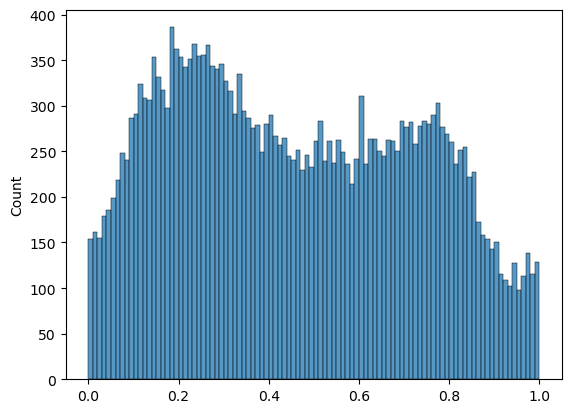

In [6]:
pseudotime_preds = []
model.eval()
model.to("cuda:7")

eval_data = CCNB1_ref_embeds

for i in tqdm(range(0, len(eval_data), batch_size)):
    x = eval_data[i:i+batch_size]
    x = x.to("cuda:7")
    theta_pred = model(x)
    y_pred = theta_pred.remainder(2 * torch.pi) / (2 * torch.pi)
    pseudotime_preds.append(y_pred.detach().cpu())
pseudotime_preds = torch.cat(pseudotime_preds, dim=0).flatten().numpy()
sns.histplot(pseudotime_preds, bins=100)
print(pseudotime_preds.shape)

In [7]:
CCNB1_dataset = CellImageDataset(DATA_DIR / f"index_{NAME}.csv", channel_colors=["pure_blue", "pure_red", "pure_green"], batch_size=batch_size)

Loading dataset images:   0%|          | 0/18 [00:00<?, ?it/s]

Loading dataset images:  94%|█████████▍| 17/18 [03:42<00:19, 19.18s/it]

In [ ]:
len(CCNB1_dataset)

25466

In [ ]:
dataloader = DataLoader(CCNB1_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [ ]:
intensity_sums = []
nonzero_pixel_ct = []

for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    intensity_sums.append(torch.sum(batch, dim=(2, 3)))
    nonzero_pixel_ct.append(torch.sum(batch > 0, dim=(2, 3)))

intensity_sums = torch.cat(intensity_sums, dim=0)
nonzero_pixel_ct = torch.cat(nonzero_pixel_ct, dim=0)

Computing mean intensities: 100%|██████████| 255/255 [02:21<00:00,  1.81it/s]


tensor(23.7967) tensor(195769.9062)
tensor(1779) tensor(563400)
tensor(0.0113) tensor(0.6686)


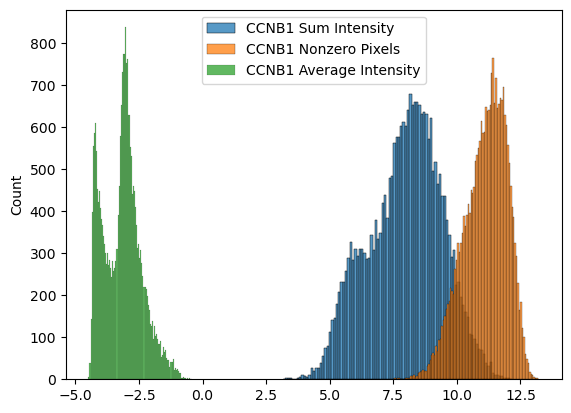

In [ ]:
CCNB1_intensity_sums, CCNB1_nonzero_pixel_ct = intensity_sums[:, 2], nonzero_pixel_ct[:, 2]
print(torch.min(CCNB1_intensity_sums), torch.max(CCNB1_intensity_sums))
sns.histplot(torch.log(CCNB1_intensity_sums), bins=100, label="CCNB1 Sum Intensity")

print(torch.min(CCNB1_nonzero_pixel_ct), torch.max(CCNB1_nonzero_pixel_ct))
sns.histplot(torch.log(CCNB1_nonzero_pixel_ct), bins=100, label="CCNB1 Nonzero Pixels")

CCNB1_average_intensity = CCNB1_intensity_sums / CCNB1_nonzero_pixel_ct
print(torch.min(CCNB1_average_intensity), torch.max(CCNB1_average_intensity))
sns.histplot(torch.log(CCNB1_average_intensity), bins=100, label="CCNB1 Average Intensity")

plt.legend()

tensor(106.9694) tensor(65817.6719)
tensor(2881) tensor(350341)
tensor(0.0261) tensor(0.7568)


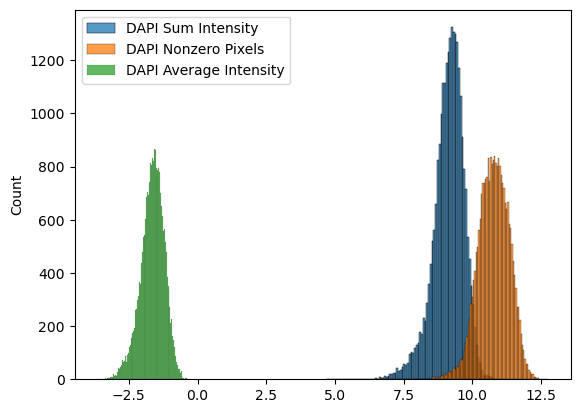

In [ ]:
DAPI_intensity_sums, DAPI_nonzero_pixel_ct = intensity_sums[:, 0], nonzero_pixel_ct[:, 0]
print(torch.min(DAPI_intensity_sums), torch.max(DAPI_intensity_sums))
sns.histplot(torch.log(DAPI_intensity_sums), bins=100, label="DAPI Sum Intensity")

print(torch.min(DAPI_nonzero_pixel_ct), torch.max(DAPI_nonzero_pixel_ct))
sns.histplot(torch.log(DAPI_nonzero_pixel_ct), bins=100, label="DAPI Nonzero Pixels")

DAPI_average_intensity = DAPI_intensity_sums / DAPI_nonzero_pixel_ct
print(torch.min(DAPI_average_intensity), torch.max(DAPI_average_intensity))
sns.histplot(torch.log(DAPI_average_intensity), bins=100, label="DAPI Average Intensity")

plt.legend()

tensor(6.2929) tensor(223578.9375)
tensor(1655) tensor(577750)
tensor(0.0038) tensor(0.6451)


<Axes: ylabel='Count'>

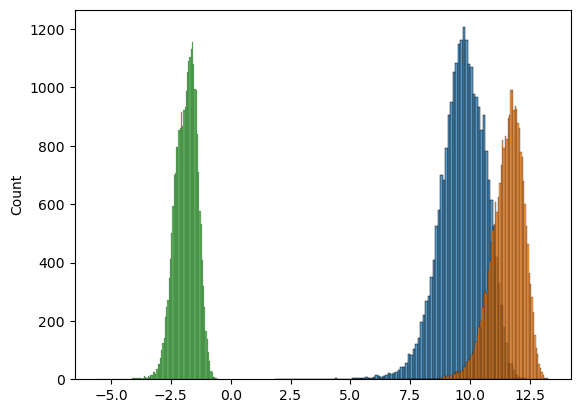

In [ ]:
TUBL_intensity_sums, TUBL_nonzero_pixel_ct = intensity_sums[:, 1], nonzero_pixel_ct[:, 1]
print(torch.min(TUBL_intensity_sums), torch.max(TUBL_intensity_sums))
sns.histplot(torch.log(TUBL_intensity_sums), bins=100, label="TUBL Sum Intensity")

print(torch.min(TUBL_nonzero_pixel_ct), torch.max(TUBL_nonzero_pixel_ct))
sns.histplot(torch.log(TUBL_nonzero_pixel_ct), bins=100, label="TUBL Nonzero Pixels")

TUBL_average_intensity = TUBL_intensity_sums / TUBL_nonzero_pixel_ct
print(torch.min(TUBL_average_intensity), torch.max(TUBL_average_intensity))
sns.histplot(torch.log(TUBL_average_intensity), bins=100, label="TUBL Average Intensity")

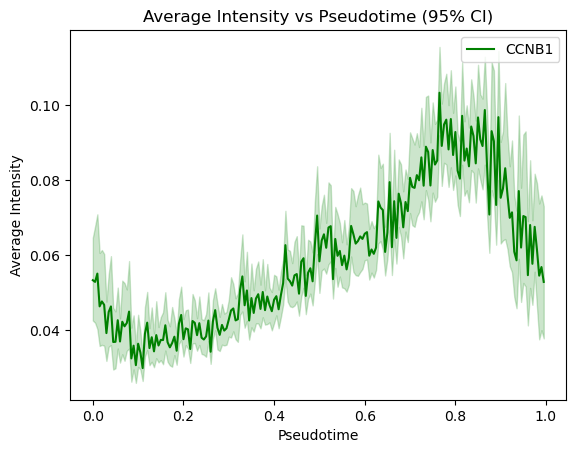

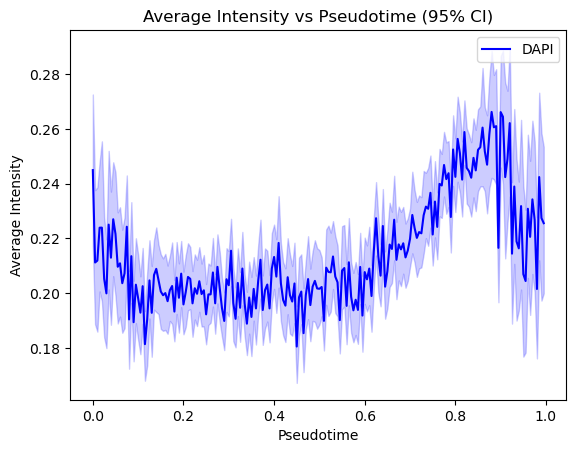

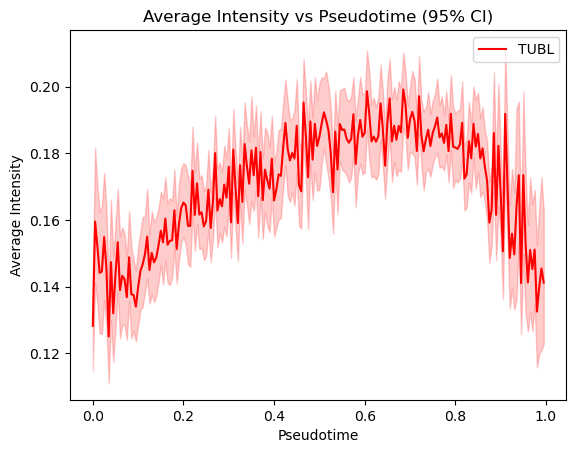

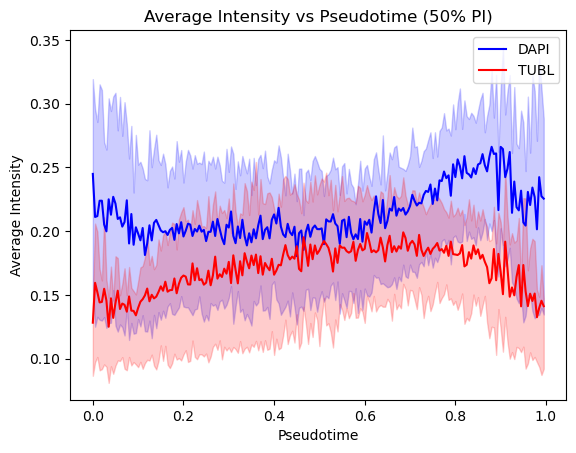

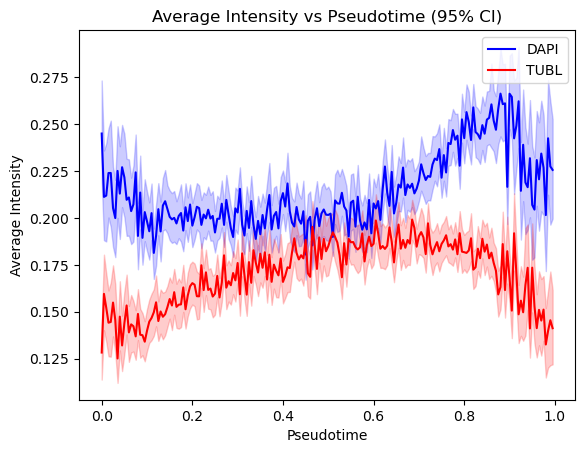

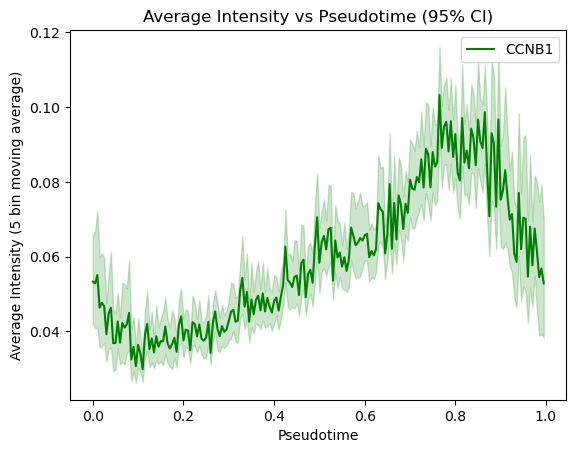

In [ ]:
bins = np.linspace(0, 1, 201)
binned_pseudotime = (np.digitize(pseudotime_preds, bins) - 1) / 200

df = pd.DataFrame({"Pseudotime": binned_pseudotime, "CCNB1": CCNB1_average_intensity, "DAPI": DAPI_average_intensity, "TUBL": TUBL_average_intensity})
ci = True
interval = 95
sns.lineplot(data=df, x="Pseudotime", y="CCNB1", errorbar=('ci' if ci else 'pi', interval), color="green", label="CCNB1")
plt.ylabel("Average Intensity")
plt.xlabel("Pseudotime")
plt.title(f"Average Intensity vs Pseudotime ({interval}% {'CI' if ci else 'PI'})")
plt.legend()
plt.show()
plt.clf()

sns.lineplot(data=df, x="Pseudotime", y="DAPI", errorbar=('ci' if ci else 'pi', interval), color="blue", label="DAPI")
plt.ylabel("Average Intensity")
plt.xlabel("Pseudotime")
plt.title(f"Average Intensity vs Pseudotime ({interval}% {'CI' if ci else 'PI'})")
plt.legend()
plt.show()
plt.clf()

sns.lineplot(data=df, x="Pseudotime", y="TUBL", errorbar=('ci' if ci else 'pi', interval), color="red", label="TUBL")
plt.ylabel("Average Intensity")
plt.xlabel("Pseudotime")
plt.title(f"Average Intensity vs Pseudotime ({interval}% {'CI' if ci else 'PI'})")
plt.legend()
plt.show()
plt.clf()

ci = False
interval = 50
sns.lineplot(data=df, x="Pseudotime", y="DAPI", errorbar=('ci' if ci else 'pi', interval), color="blue", label="DAPI")
sns.lineplot(data=df, x="Pseudotime", y="TUBL", errorbar=('ci' if ci else 'pi', interval), color="red", label="TUBL")
plt.ylabel("Average Intensity")
plt.xlabel("Pseudotime")
plt.title(f"Average Intensity vs Pseudotime ({interval}% {'CI' if ci else 'PI'})")
plt.legend()
plt.show()
plt.clf()

ci = True
interval = 95
sns.lineplot(data=df, x="Pseudotime", y="DAPI", errorbar=('ci' if ci else 'pi', interval), color="blue", label="DAPI")
sns.lineplot(data=df, x="Pseudotime", y="TUBL", errorbar=('ci' if ci else 'pi', interval), color="red", label="TUBL")
plt.ylabel("Average Intensity")
plt.xlabel("Pseudotime")
plt.title(f"Average Intensity vs Pseudotime ({interval}% {'CI' if ci else 'PI'})")
plt.legend()
plt.show()
plt.clf()

# now a version of the plot above with smoothing at a 5 bin window
sns.lineplot(data=df, x="Pseudotime", y="CCNB1", errorbar=('ci' if ci else 'pi', interval), color="green", label="CCNB1")
# sns.lineplot(data=df, x="Pseudotime", y="DAPI", errorbar=('ci' if ci else 'pi', interval), color="blue", label="DAPI")
# sns.lineplot(data=df, x="Pseudotime", y="TUBL", errorbar=('ci' if ci else 'pi', interval), color="red", label="TUBL")
plt.ylabel("Average Intensity (5 bin moving average)")
plt.xlabel("Pseudotime")
plt.title(f"Average Intensity vs Pseudotime ({interval}% {'CI' if ci else 'PI'})")
plt.legend()
plt.show()

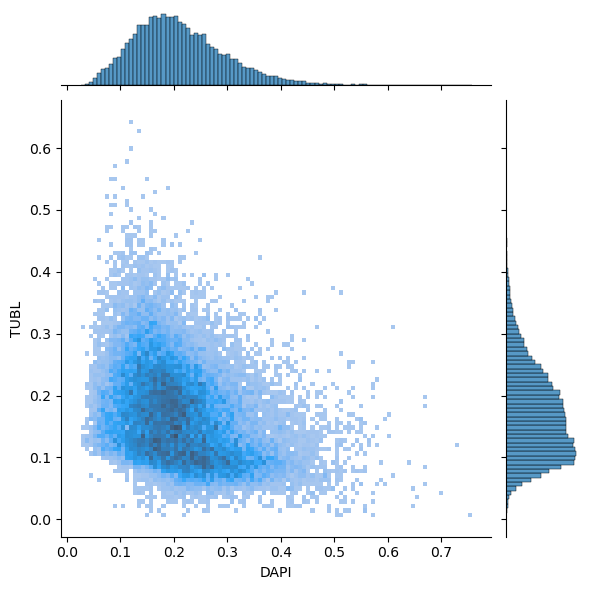

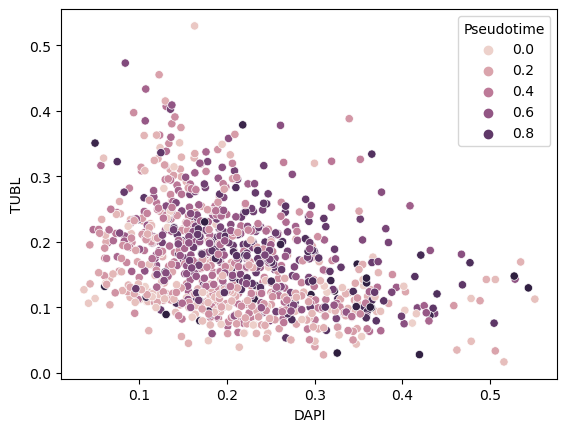

In [ ]:
sns.jointplot(data=df, x="DAPI", y="TUBL", kind="hist")
plt.show()
plt.clf()

# scatter plot with points colored by pseudotime, sample 1000 points
sample_idx = np.random.choice(len(df), size=1000, replace=False)
sns.scatterplot(data=df.iloc[sample_idx], x="DAPI", y="TUBL", hue="Pseudotime")
plt.show()

In [ ]:
def two_sig_fig_floor(x):
    return torch.floor(x / torch.pow(10.0, torch.floor(torch.log10(x)) - 1)) * torch.pow(10.0, torch.floor(torch.log10(x)) - 1)

def clean_intensities_for_log_errors(CCNB1_nonzero_pixel_ct, CCNB1_intensity_sums, silent=True):
    if not silent: print("Number of nonzero pixels, min/max")
    if not silent: print(torch.min(CCNB1_nonzero_pixel_ct), torch.max(CCNB1_nonzero_pixel_ct))

    if not silent: print("\nNumber of nonzero pixels, min with and min without looking at images with 0 nonzero pixels")
    nonzero_0 = CCNB1_nonzero_pixel_ct.nonzero().flatten()

    if not silent: print(torch.min(CCNB1_nonzero_pixel_ct[nonzero_0]), torch.min(CCNB1_nonzero_pixel_ct))
    CCNB1_nonzero_ct_eps = torch.tensor([torch.min(CCNB1_nonzero_pixel_ct[nonzero_0])])
    CCNB1_nonzero_ct_eps = two_sig_fig_floor(CCNB1_nonzero_ct_eps)
    if not silent: print("eps: ", CCNB1_nonzero_ct_eps)

    if (torch.min(CCNB1_nonzero_pixel_ct) < 0).all():
        raise ValueError("Negative number of nonzero pixels")
    elif (torch.min(CCNB1_nonzero_pixel_ct) > 0).all():
        CCNB1_nonzero_ct_eps *= 0

    if not silent: print("\nIntensity of nonzero cells, min/max")
    if not silent: print(torch.min(CCNB1_intensity_sums), torch.max(CCNB1_intensity_sums))

    if not silent: print("\nIntensity of nonzero cells, min and min without looking at images with 0 nonzero pixels")
    nonzero_0 = CCNB1_intensity_sums.nonzero().flatten()

    if not silent: print(torch.min(CCNB1_intensity_sums[nonzero_0]), torch.min(CCNB1_intensity_sums))
    CCNB1_sum_eps = torch.tensor([torch.min(CCNB1_intensity_sums[nonzero_0])])
    CCNB1_sum_eps = two_sig_fig_floor(CCNB1_sum_eps)
    if not silent: print("eps: ", CCNB1_sum_eps)

    if (torch.min(CCNB1_intensity_sums) < 0).all():
        raise ValueError("Negative intensity")
    elif (torch.min(CCNB1_intensity_sums) > 0).all():
        CCNB1_sum_eps *= 0

    return CCNB1_nonzero_ct_eps, CCNB1_sum_eps

CCNB1_nonzero_ct_eps, CCNB1_sum_eps = clean_intensities_for_log_errors(CCNB1_nonzero_pixel_ct, CCNB1_intensity_sums)
DAPI_nonzero_ct_eps, DAPI_sum_eps = clean_intensities_for_log_errors(DAPI_nonzero_pixel_ct, DAPI_intensity_sums)
TUBL_nonzero_ct_eps, TUBL_sum_eps = clean_intensities_for_log_errors(TUBL_nonzero_pixel_ct, TUBL_intensity_sums)

print("CCNB1 nonzero ct eps: ", CCNB1_nonzero_ct_eps, "CCNB1 sum eps: ", CCNB1_sum_eps)
print("DAPI nonzero ct eps: ", DAPI_nonzero_ct_eps, "DAPI sum eps: ", DAPI_sum_eps)
print("TUBL nonzero ct eps: ", TUBL_nonzero_ct_eps, "TUBL sum eps: ", TUBL_sum_eps)

CCNB1 nonzero ct eps:  tensor([0.]) CCNB1 sum eps:  tensor([0.])
DAPI nonzero ct eps:  tensor([0.]) DAPI sum eps:  tensor([0.])
TUBL nonzero ct eps:  tensor([0.]) TUBL sum eps:  tensor([0.])


In [ ]:
CCNB1_mean_log_intensity = torch.log10((CCNB1_intensity_sums + CCNB1_sum_eps) / (CCNB1_nonzero_pixel_ct + CCNB1_nonzero_ct_eps))
DAPI_mean_log_intensity = torch.log10((DAPI_intensity_sums + DAPI_sum_eps) / (DAPI_nonzero_pixel_ct + DAPI_nonzero_ct_eps))
TUBL_mean_log_intensity = torch.log10((TUBL_intensity_sums + TUBL_sum_eps) / (TUBL_nonzero_pixel_ct + TUBL_nonzero_ct_eps))
CCNB1_total_log_intensity = torch.log10((CCNB1_intensity_sums + CCNB1_sum_eps))
DAPI_total_log_intensity = torch.log10((DAPI_intensity_sums + DAPI_sum_eps))
TUBL_total_log_intensity = torch.log10((TUBL_intensity_sums + TUBL_sum_eps))

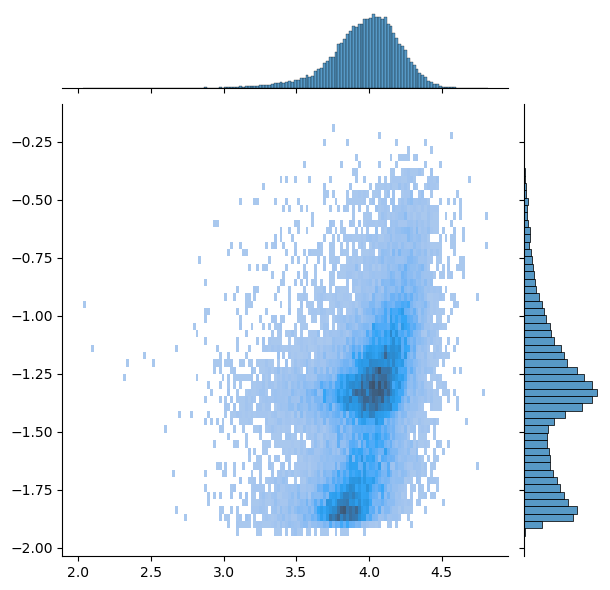

<Axes: >

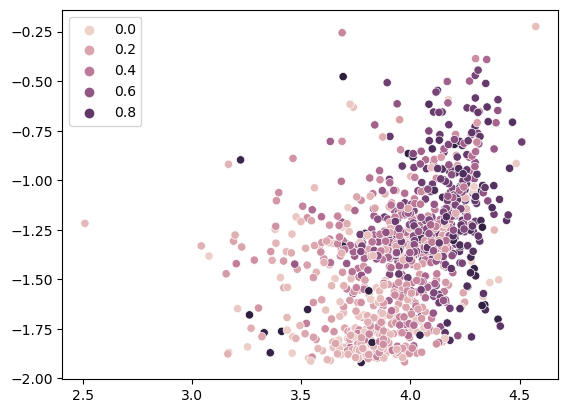

In [ ]:
sns.jointplot(x=DAPI_total_log_intensity, y=CCNB1_mean_log_intensity, kind="hist")
plt.show()
plt.clf()

# scatter plot of mean log intensities, colored by pseudotime, of 1000 points
sns.scatterplot(x=DAPI_total_log_intensity[sample_idx], y=CCNB1_mean_log_intensity[sample_idx], hue=binned_pseudotime[sample_idx])

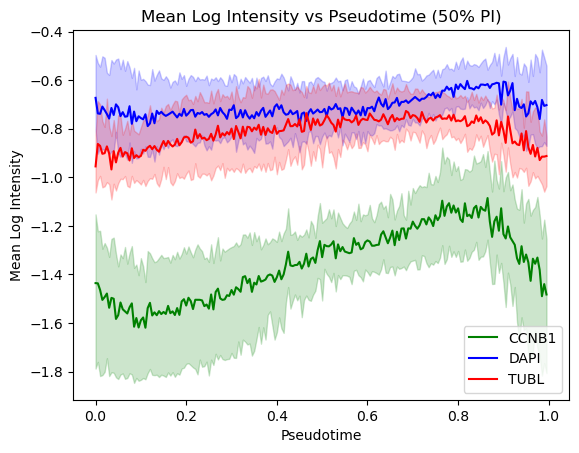

In [ ]:
# pseudotime plots of the mean log intensities for each channel
df = pd.DataFrame({"Pseudotime": binned_pseudotime, "CCNB1": CCNB1_mean_log_intensity, "DAPI": DAPI_mean_log_intensity, "TUBL": TUBL_mean_log_intensity})
sns.lineplot(data=df, x="Pseudotime", y="CCNB1", errorbar=('ci' if ci else 'pi', interval), color="green", label="CCNB1")
sns.lineplot(data=df, x="Pseudotime", y="DAPI", errorbar=('ci' if ci else 'pi', interval), color="blue", label="DAPI")
sns.lineplot(data=df, x="Pseudotime", y="TUBL", errorbar=('ci' if ci else 'pi', interval), color="red", label="TUBL")
plt.ylabel("Mean Log Intensity")
plt.xlabel("Pseudotime")
plt.title(f"Mean Log Intensity vs Pseudotime ({interval}% {'CI' if ci else 'PI'})")
plt.legend()
plt.show()

[0.58009493 0.283759  ]


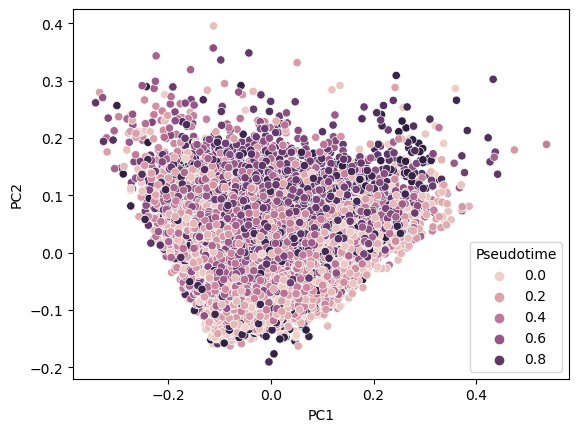

In [ ]:
# PCA of the mean log intensities plotted with color by pseudotime
pca = PCA(n_components=2)
pca.fit(df[["CCNB1", "DAPI", "TUBL"]])
pca_df = pd.DataFrame(pca.transform(df[["CCNB1", "DAPI", "TUBL"]]), columns=["PC1", "PC2"])
pca_df["Pseudotime"] = df["Pseudotime"]
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Pseudotime")
print(pca.explained_variance_ratio_)

In [ ]:
# bin the data by pseudotime and then plot the first pc components for each channel over time
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

n_bins = 50
bins = np.linspace(0, 1, n_bins + 1)
binned_pseudotime = (np.digitize(pseudotime_preds, bins) - 1) / n_bins
df_dict = {"CCNB1": CCNB1_mean_log_intensity, "DAPI": DAPI_total_log_intensity, "TUBL": TUBL_total_log_intensity}

Text(0.5, 0, 'TUBL')

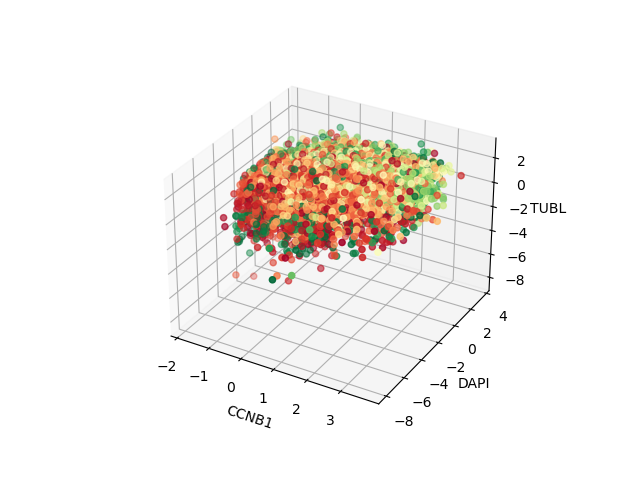

In [ ]:
# plot DAPI, TUBL, and CCNB1 in 3D, colored by pseudotime
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["CCNB1"], df["DAPI"], df["TUBL"], c=df["Pseudotime"], cmap="RdYlGn")
ax.set_xlabel("CCNB1")
ax.set_ylabel("DAPI")
ax.set_zlabel("TUBL")

100%|██████████| 30/30 [00:00<00:00, 65.18it/s]


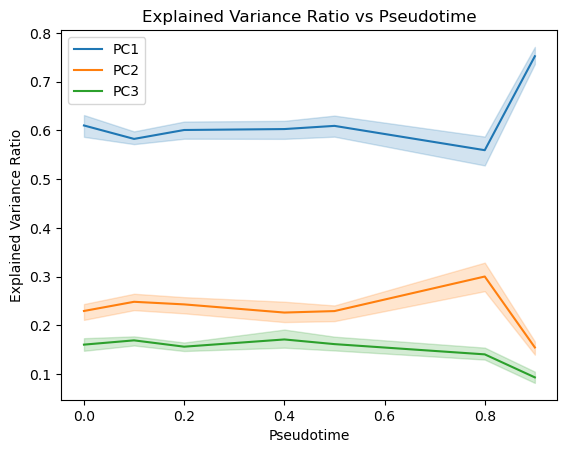

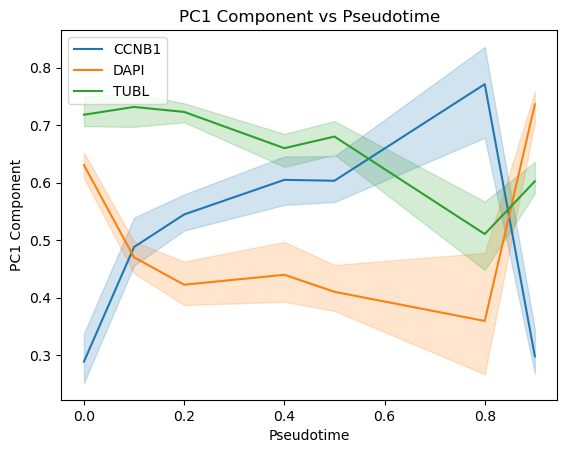

In [ ]:
# do the above but with 50 subsamples of the data, then plot the average the 95% CI

ci = False
interval = 75
n_bins = 10
n_replicates = 30
sample_size = 6000
min_sample = 30
bins = np.linspace(0, 1, n_bins + 1)
binned_pseudotime = (np.digitize(pseudotime_preds, bins) - 1) / n_bins

explained_variance_ratios = []
pcs = []
for n in tqdm(range(n_replicates)):
    samples = np.random.choice(len(df), size=sample_size, replace=True)
    df_dict = {"CCNB1": CCNB1_mean_log_intensity[samples], "DAPI": DAPI_total_log_intensity[samples], "TUBL": TUBL_total_log_intensity[samples]}
    scaler = StandardScaler()
    for k in df_dict.keys():
        df_dict[k] = scaler.fit_transform(df_dict[k].reshape(-1, 1)).flatten()
    df_dict["Pseudotime"] = binned_pseudotime[samples]

    df = pd.DataFrame(df_dict)

    sample_explained_variance_ratios = []
    sample_pcs = []
    for t in bins[:-1]:
        pca = PCA(n_components=3)
        if len(df[df["Pseudotime"] == t]) < min_sample:
            sample_explained_variance_ratios.append(np.array([np.nan, np.nan, np.nan]))
            sample_pcs.append(np.array([[np.nan, np.nan, np.nan] for i in range(3)]))
            continue
        pca.fit(df[df["Pseudotime"] == t][["CCNB1", "DAPI", "TUBL"]])
        sample_explained_variance_ratios.append(pca.explained_variance_ratio_)
        sample_pcs.append(pca.components_)

    explained_variance_ratios.append(np.array(sample_explained_variance_ratios))
    pcs.append(np.array(sample_pcs))

explained_variance_ratios = np.concatenate(explained_variance_ratios)
pcs = np.concatenate(pcs)

df = pd.DataFrame({"PC1": explained_variance_ratios[:, 0], "PC2": explained_variance_ratios[:, 1], "PC3": explained_variance_ratios[:, 2], "Pseudotime": np.tile(bins[:-1], n_replicates)})
sns.lineplot(data=df, x="Pseudotime", y="PC1", errorbar=('ci' if ci else 'pi', interval), label="PC1")
sns.lineplot(data=df, x="Pseudotime", y="PC2", errorbar=('ci' if ci else 'pi', interval), label="PC2")
sns.lineplot(data=df, x="Pseudotime", y="PC3", errorbar=('ci' if ci else 'pi', interval), label="PC3")
plt.xlabel("Pseudotime")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio vs Pseudotime")
plt.legend()
plt.show()

df = pd.DataFrame({"CCNB1": np.abs(pcs[:, 0, 0]), "DAPI": np.abs(pcs[:, 0, 1]), "TUBL": np.abs(pcs[:, 0, 2]), "Pseudotime": np.tile(bins[:-1], n_replicates)})
sns.lineplot(data=df, x="Pseudotime", y="CCNB1", errorbar=('ci' if ci else 'pi', interval), label="CCNB1")
sns.lineplot(data=df, x="Pseudotime", y="DAPI", errorbar=('ci' if ci else 'pi', interval), label="DAPI")
sns.lineplot(data=df, x="Pseudotime", y="TUBL", errorbar=('ci' if ci else 'pi', interval), label="TUBL")
plt.xlabel("Pseudotime")
plt.ylabel("PC1 Component")
plt.title("PC1 Component vs Pseudotime")
plt.legend()
plt.show()
